In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import glob
import os
import numpy as np
import pandas as pd
import random
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from tqdm import tqdm

import train_p2
from torchsummary import summary
import digit_classifier as dc

In [25]:
image_size = 28
lv_size = 100
channel_size = 3
G_fs = 28
D_fs = 28
num_classes = 10
lr_G = 0.0002
lr_D = 0.00025
beta1 = 0.5
epochs = 500
batch_size=256
save_model_dir = './save_models/'
manualSeed = 86

In [ ]:

trainset = train_p2.p2(root='hw2_data/digits/mnistm/train',label_path='hw2_data/digits/mnistm/train.csv')

print('# images in trainset:', len(trainset))

trainset_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

dataiter = iter(trainset_loader)
images, labels = dataiter.next()
print('(Trainset) Image tensor in each batch:', images.shape, images.dtype)
print('(Trainset) Label tensor in each batch:', labels.shape, labels.dtype)

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

G_model = train_p2.Generator().to(device)
G_model.apply(train_p2.weights_init)

D_model = train_p2.Discriminator().to(device)
D_model.apply(train_p2.weights_init)

net = dc.Classifier()
path = "Classifier.pth"
dc.load_checkpoint(path, net)
net = net.to(device)

# summary(G_model,(100,1,1))
# summary(D_model,(3,64,64))

criterion_real_fake = nn.BCELoss()
criterion_classes = nn.CrossEntropyLoss()

real_label = 1
fake_label = 0

G_optimizer = optim.Adam(G_model.parameters(), lr=lr_G, betas=(beta1, 0.999))
D_optimizer = optim.Adam(D_model.parameters(), lr=lr_D, betas=(beta1, 0.999))

G_losses_real_fake = []
D_losses_real_fake = []
G_losses_classes = []
D_losses_classes = []

data_size = len(trainset_loader)

best_acc = 0.0
best_epoch = 0

print("Start Training ...")
for epoch in range(1, epochs+1):

    G_loss_real_fake_total = 0.0
    D_loss_real_fake_total = 0.0
    G_loss_classes_total = 0.0
    D_loss_classes_total = 0.0

    for _, (data, label_classes) in enumerate(tqdm(trainset_loader)):
        data, label_classes = data.to(device), label_classes.to(device)

        # Discriminator training with real images
        D_optimizer.zero_grad()

        b_size = data.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        real_fake, classes = D_model(data)
        D_loss_real_fake = criterion_real_fake(real_fake,label)
        D_loss_classes = criterion_classes(classes, label_classes)

        D_loss_real_fake_total += D_loss_real_fake.item()
        D_loss_classes_total += D_loss_classes.item()

        D_real_loss = D_loss_real_fake + D_loss_classes
        D_real_loss.backward()

        # Discriminator training with fake images
        label_ = np.random.randint(0, num_classes, b_size)
        noise_ = np.random.normal(0, 1, (b_size, lv_size))
        label_onehot = np.zeros((b_size, num_classes))
        label_onehot[np.arange(b_size), label_] = 1
        noise_[np.arange(b_size), :num_classes] = label_onehot[np.arange(b_size)]
        
        noise_ = (torch.from_numpy(noise_))
        noise_ = noise_.resize_(b_size, lv_size, 1, 1)
        noise = torch.randn(b_size, lv_size, 1, 1, device=device)
        noise.data.copy_(noise_)
        fake_classes_label = torch.randint(0,10,(b_size,), device=device)
        fake_classes_label.data.resize_(b_size).copy_(torch.from_numpy(label_))
        fake_imgs = G_model(noise)
        label.fill_(fake_label)
        real_fake, classes = D_model(fake_imgs.detach())
        D_loss_real_fake = criterion_real_fake(real_fake,label)

        D_loss_classes = criterion_classes(classes, fake_classes_label)

        D_loss_real_fake_total += D_loss_real_fake.item()
        D_loss_classes_total += D_loss_classes.item()

        D_fake_loss = D_loss_real_fake + D_loss_classes
        D_fake_loss.backward()
            
        D_optimizer.step()

        ## Generator training
        G_model.zero_grad()
        label.fill_(real_label)

        real_fake, classes = D_model(fake_imgs)
        G_loss_real_fake = criterion_real_fake(real_fake,label)
        G_loss_classes = criterion_classes(classes, fake_classes_label)

        G_loss_real_fake_total += G_loss_real_fake.item()
        G_loss_classes_total += G_loss_classes.item()

        G_loss = G_loss_real_fake + G_loss_classes
        G_loss.backward()

        G_optimizer.step()
        
    D_loss_real_fake_total /= data_size
    D_loss_classes_total /= data_size
    G_loss_real_fake_total /= data_size
    G_loss_classes_total /= data_size
    
    # valid Generator performance\
    np.random.seed(manualSeed)
    random.seed(manualSeed)
    torch.manual_seed(manualSeed)
    torch.cuda.manual_seed_all(manualSeed)
    size = 100
    classes_list = []
    img_names = []
    cnt = 0
    G_model.eval()
    for i in range(10):
        labels = np.random.randint(i, i+1, size)
        noises = np.random.normal(0, 1, (size, lv_size))
        label_onehot = np.zeros((size, num_classes))
        label_onehot[np.arange(size), labels] = 1
        noises[np.arange(size), :num_classes] = label_onehot[np.arange(size)]
        noise_ = (torch.from_numpy(noises))
        noise_ = noise_.resize_(size, lv_size, 1, 1)
        noise = torch.randn(size, lv_size, 1, 1, device=device)
        noise.data.copy_(noise_)
        
        output = G_model(noise)

        classes = net(output)
        for x, img in enumerate(output):
            img_name = f'{i}_{x+1:03d}.png'
            # imgio.imsave(os.path.join('./save_images', f'{i:04d}.jpg'), img)
            vutils.save_image(img, os.path.join('./save_digits', img_name), normalize=True)
            img_names.append(img_name)
            class_label = int(classes[x].argmax(dim=-1).cpu().numpy())
            classes_list.append(class_label)
            if class_label == i:
                cnt += 1
    
    acc = cnt / 1000 * 100
    if acc > best_acc:
        best_acc = acc
        torch.save(G_model.state_dict(), os.path.join(save_model_dir,'G_model.pth'))
        torch.save(D_model.state_dict(), os.path.join(save_model_dir,'D_model.pth'))
        best_epoch = epoch
        
        
    print(f"[ Train | {epoch:03d}/{epochs:03d} ] Accuracy = {acc:.2f}%, D_loss_real_fake = {D_loss_real_fake_total:.4f}, D_loss_classes = {D_loss_classes_total:.4f}, G_loss_real_fake = {G_loss_real_fake_total:.4f}, G_loss_classes = {G_loss_classes_total:.4f}")
        
    D_losses_real_fake.append(D_loss_real_fake_total)
    D_losses_classes.append(D_loss_classes_total)
    G_losses_real_fake.append(G_loss_real_fake_total)
    G_losses_classes.append(G_loss_classes_total)

    if epoch % 50 == 0:
        noise = torch.randn((32), lv_size, 1, 1, device=device)
        fake = G_model(noise)
        fig = plt.figure(figsize=(8,8))
        plt.axis("off")
        plt.imshow(np.transpose(vutils.make_grid(fake.detach().cpu()[0:32], nrow=8, padding=2, normalize=True),(1,2,0)))
        plt.show()

best_acc: 82.3, best_epoch: 499


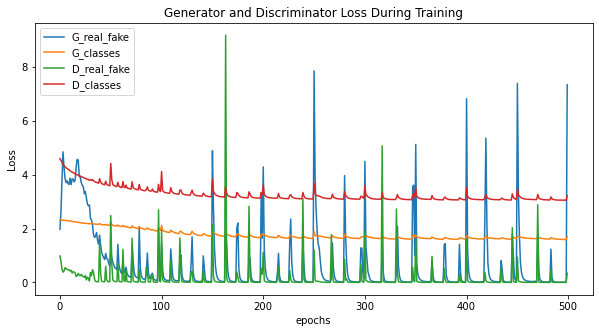

In [37]:
print(f'best_acc: 82.3, best_epoch: {best_epoch}')
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses_real_fake[:500],label="G_real_fake")
plt.plot(G_losses_classes[:500],label="G_classes")
plt.plot(D_losses_real_fake[:500],label="D_real_fake")
plt.plot(D_losses_classes[:500],label="D_classes")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [46]:
G1 = train_p2.Generator().to(device)
G1.load_state_dict(torch.load('./save_models/acgan_generatorl_499ep_0.8234.pth'))

best_accuracy = 0.0
best_rs = 0
print("Random Seed: ", manualSeed)
np.random.seed(manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed_all(manualSeed)

size = 100
classes_list = []
img_names = []
cnt = 0
first = True
for i in range(10):
    labels = np.random.randint(i, i+1, size)
    noises = np.random.normal(0, 1, (size, lv_size))
    label_onehot = np.zeros((size, num_classes))
    label_onehot[np.arange(size), labels] = 1
    noises[np.arange(size), :num_classes] = label_onehot[np.arange(size)]
    noise_ = (torch.from_numpy(noises))
    noise_ = noise_.resize_(size, lv_size, 1, 1)
    noise = torch.randn(size, lv_size, 1, 1, device=device)
    noise.data.copy_(noise_)

    G1.eval()
    output = G1(noise)
        
    first = False

    classes = net(output)
    for x, img in enumerate(output):
        img_name = f'{i}_{x+1:03d}.png'
        # imgio.imsave(os.path.join('./save_images', f'{i:04d}.jpg'), img)
        vutils.save_image(img, os.path.join('./save_digits', img_name), normalize=True)
        img_names.append(img_name)
        class_label = int(classes[x].argmax(dim=-1).cpu().numpy())
        classes_list.append(class_label)
        if class_label == i:
             cnt += 1
    
print(f'Accuracy: {cnt / 1000 * 100:.2f}')

Random Seed:  86
Accuracy: 82.40


Random Seed:  86


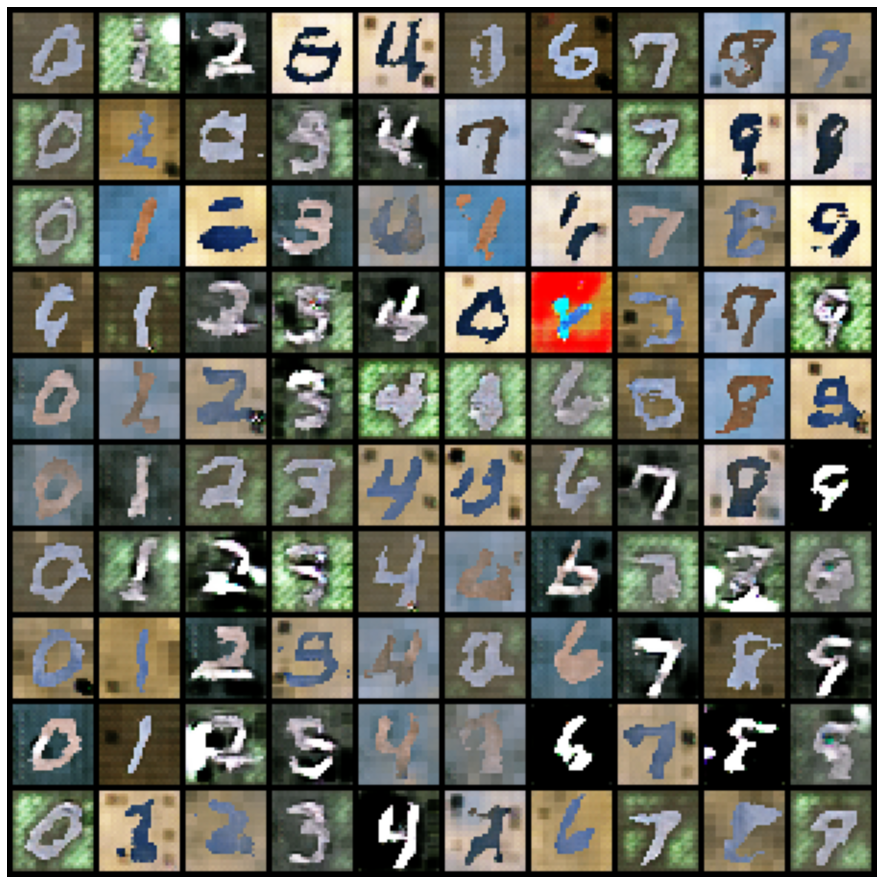

In [43]:
Seed = 86
print("Random Seed: ", Seed)
np.random.seed(Seed)
random.seed(Seed)
torch.manual_seed(Seed)
torch.cuda.manual_seed_all(Seed)
size = 10
first = True
for _ in range(10):
    labels = np.arange(10)
    noises = np.random.normal(0, 1, (size, lv_size))
    label_onehot = np.zeros((size, num_classes))
    label_onehot[np.arange(size), labels] = 1
    noises[np.arange(size), :num_classes] = label_onehot[np.arange(size)]
    noise_ = (torch.from_numpy(noises))
    noise_ = noise_.resize_(size, lv_size, 1, 1)
    noise = torch.randn(size, lv_size, 1, 1, device=device)
    noise.data.copy_(noise_)

    G1.eval()
    output = G1(noise)
    if first:
        outputs = output
    else:
        outputs = torch.cat((outputs,output),0)
        
    first = False
    
fig = plt.figure(figsize=(16,16))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(outputs.detach().cpu()[0:100], nrow=10, padding=2, normalize=True),(1,2,0)))
    # classes = net(output)
    # for x, img in enumerate(output):
    #     img_name = f'{i}_{x+1:03d}.png'
    #     # imgio.imsave(os.path.join('./save_images', f'{i:04d}.jpg'), img)
    #     # vutils.save_image(img, os.path.join('./save_digits', img_name), normalize=True)
    #     img_names.append(img_name)
    #     class_label = int(classes[x].argmax(dim=-1).cpu().numpy())
    #     classes_list.append(class_label)
    #     if class_label == i:
    #          cnt += 1

In [ ]:
# size = 100
# classes_list = []
# img_names = []
# cnt = 0
# for i in range(10):
#     labels = np.random.randint(i, i+1, size)
#     noises = np.random.normal(0, 1, (size, lv_size))
#     label_onehot = np.zeros((size, num_classes))
#     label_onehot[np.arange(size), labels] = 1
#     noises[np.arange(size), :num_classes] = label_onehot[np.arange(size)]
#     noise_ = (torch.from_numpy(noises))
#     noise_ = noise_.resize_(size, lv_size, 1, 1)
#     noise = torch.randn(size, lv_size, 1, 1, device=device)
#     noise.data.copy_(noise_)

#     G_model.eval()
#     output = G_model(noise)

#     classes = net(output)
#     for x, img in enumerate(output):
#         img_name = f'{i}_{x+1:03d}.png'
#         # imgio.imsave(os.path.join('./save_images', f'{i:04d}.jpg'), img)
#         vutils.save_image(img, os.path.join('./save_digits', img_name), normalize=True)
#         img_names.append(img_name)
#         class_label = int(classes[x].argmax(dim=-1).cpu().numpy())
#         classes_list.append(class_label)
#         if class_label == i:
#             cnt += 1

# print(f'Accuracy: {cnt / 1000}')
# result = pd.DataFrame({'image_name':img_names, 'label':classes_list})
# print(result)
# result.to_csv('./result.csv',index=False)